# GetDataRehabCenters

This notebook scrapes information about the number of drug rehabilition programs in each US county.

In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import string
import requests
import time

The information is scraped from www.addiction.org. The desired information (number of clinics/county) is nested through several levels. The basic directory gives links for each state. One of these links is to a page that gives links for each county. Finally, the page for the individual county pages list the actual facilities, which can be counted.

First, start by getting the base directory page.

In [2]:
base_address = "http://www.addicted.org";

In [3]:
directory_path = "/directory.html";

try:
    directory_html = requests.get("{0}{1}".format(base_address, directory_path));
    print "Successfully acquired directory page.";
except:
    print "Failed to get directory page.";

Successfully acquired directory page.


The typical scraping procedure is to use requests to get the html, to parse this with BeautifulSoup, and finally find fields of interest. The html was requested above, and the rest of the procedure is done below.

The links to the pages listing each county within the state is found in a list html list. Note that not all of the entries are actual states! Finding all of the list elements pulls in these 'spurious' entries as well. The actual links are found within each list element. The link with "counties" or "county" in the entry is the one of interest, and the (relative) url is stored in the normal href attribute.

In [4]:
directory_soup = BeautifulSoup(directory_html.text, "html.parser");

html_entries = directory_soup.findAll("ul", attrs={"class": "sub-categories"});
print 'Found {0} "states".'.format(len(html_entries));

state_paths = [];
for state in html_entries:
    facility_type_entries = state.findAll("a");
    
    for entry in facility_type_entries:
        if ("counties" in entry.get_text().lower() or
            "county"   in entry.get_text().lower()):
            state_paths.append(entry.attrs["href"]);

print "Found {0} states with per county breakdown.".format(len(state_paths));

Found 54 "states".
Found 50 states with per county breakdown.


Diving further into the nested procedure, the next step is to get the (relative) urls for each individual county. In preparation for joining to other datasets, the desired output will contain the state and county name, so the formatting for that information begins here.

A map from the state name to the two letter abbreviation is used for the state. This information will be collected from the state url, so this includes any typos (orego for Oregon), hyphens for states with multiple words, and other possible details (parishes for Louisiana).

The form of the state url is a 20 character string, <code>/directory/category/</code>, followed by the snippet <code>statename-counties</code>, and finally by the appendix <code>.html</code>. To get the state name, only the snippet <code>statename-counties</code> is pulled from the url. This is split on the final hyphen (from the right, hence <code>rsplit</code>), and the first token is entered as the state map key.

Finally, the individual (relative) urls for each county are stored in a dictionary, where the county path is the key, and the abbreviated state name as the value.

In [15]:
county_paths = {};
old_total = 0;

state_map = {'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR', 'california': 'CA',
             'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
             'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA',
             'kansas': 'KS', 'kentucky': 'KY', 'louisiana-parishes': 'LA', 'maine': 'ME', 'maryland': 'MD',
             'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS', 'missouri': 'MO',
             'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'new-hampshire': 'NH', 'new-jersey': 'NJ',
             'new-mexico': 'NM', 'new-york': 'NY', 'north-carolina': 'NC', 'north-dakota': 'ND', 'ohio': 'OH',
             'oklahoma': 'OK', 'orego': 'OR', 'pennsylvania': 'PA', 'rhode-island': 'RI', 'south-carolina': 'SC',
             'south-dakota': 'SD', 'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT', 'vermont': 'VT',
             'virginia': 'VA', 'washington': 'WA', 'west-virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY'};

for path in state_paths:
    time.sleep(1.);
    try:
        state_html = requests.get("{0}{1}".format(base_address, path));
    except:
        print "Failed to get html for relative path {0}.".format(path);
        continue;
    
    state_soup = BeautifulSoup(state_html.text, "html.parser");
    html_entries = state_soup.findAll("a");
    
    for county in html_entries:
        if "county" in county.get_text().lower():
            county_paths[(county.attrs["href"])] = state_map[path[20:-5].rsplit('-',1)[0]];
    
    print "{0}: Found {1} counties.".format(path, len(county_paths)-old_total);
    old_total = len(county_paths);

print "Found {0} total counties.".format(len(county_paths));

/directory/category/alabama-counties.html: Found 30 counties.
/directory/category/alaska-boroughs.html: Found 8 counties.
/directory/category/arizona-counties.html: Found 8 counties.
/directory/category/arkansas-counties.html: Found 30 counties.
/directory/category/california-counties.html: Found 39 counties.
/directory/category/colorado-counties.html: Found 21 counties.
/directory/category/connecticut-counties.html: Found 6 counties.
/directory/category/delaware-counties.html: Found 3 counties.
/directory/category/florida-counties.html: Found 35 counties.
/directory/category/georgia-counties.html: Found 29 counties.
/directory/category/hawaii-counties.html: Found 4 counties.
/directory/category/idaho-counties.html: Found 8 counties.
/directory/category/illinois-counties.html: Found 28 counties.
/directory/category/indiana-counties.html: Found 22 counties.
/directory/category/iowa-counties.html: Found 27 counties.
/directory/category/kansas-counties.html: Found 17 counties.
/directory/

This is the final layer of the nested procedure that pulls the total number of facilities. The html for each county is accessed first to make sure the final dictionary entry will be valid. The county is skipped otherwise.

With a successful request, the county name is formatted further. Since the relative path to the county does not include the state, there are many duplicate county names. Thus, the general format for the relative county url is <code>/directory/category/countyname(-modifier)-county(-number).html</code>, where <code>(-modifier)</code> is an additional piece for states where there are similarly named divisions that are not counties, and <code>(-number)</code> is the modifier to distinguish urls for duplicate counties.

First, the county name discards the same prefix and suffix as above and converts hyphens to spaces. The remaining string is tokenized and the individual words in the county name are capitalized. A check is then performed whether the last word is a digit. If it is, the string is split on only the last space, and the county is taken as the first word, discarding the digit (and space before it). Next, if two county style designation exist in the name (i.e., county and borough), the word 'county' is discarded. Finally, if no county style designation exists, the appropriate one is appended, based on the state.

The next logic gets the number of facilities. If there are more than 20, then the facilities are listed on mulitple pages. A check is performed for the html element that links to each page. If none is found, the total number of facilities are counted based on the appropriate element. If the pagination element is found, the last page is accessed and the total number of facilities is counted on this page. The actual url referenced by the 'Last' button includes the actual page number, so this is pulled to calculate the real total, using the fact that all pages before the final page have a full 20 facilities.

The final dictionary format is a dictionary of lists. Once the state, county, and number of facilities are all formatted/calculated, they are appended to the appropriate list.

One future improvement could consider the tags associated with each facility. Of course, this would require visiting each page when the facilities are listed over multiple pages.

In [26]:
rehab_dict = {'state': [], 'county': [], 'n_facilities': []};
iterator = 1;

for path in county_paths:
    if iterator % 20 == 0:
        print 'On iteration {0}.'.format(iterator);
    iterator += 1;
    
    county = '';
    state = '';
    n_facilities = -1;
    
    time.sleep(1.);
    try:
        county_html = requests.get("{0}{1}".format(base_address, path));
    except:
        print "Failed to get html for relative path {0}.".format(path);
        continue;
    
    county_soup = BeautifulSoup(county_html.text, "html.parser");
    
    state = county_paths[path];
    county = string.capwords(path[20:-5].replace('-',' '));
    if county.rsplit(' ', 1)[-1].isdigit():
        county = county.rsplit(' ', 1)[0];
    if(('County' in county and 'Borough' in county) or
       ('County' in county and 'Parish' in county)):
        county = county.replace(' County', '');
    if('County' not in county and 'Borough' not in county and 'Parish' not in county):
        if state == 'AK':
            county = ' '.join([county, 'Borough']);
        elif state == 'LA':
            county = ' '.join([county, 'Parish']);
        else:
            county = ' '.join([county, 'County']);
    
    county = ', '.join([county, state])
    
    html_entries = county_soup.findAll("ul", attrs={"class": "uk-pagination"});
    if len(html_entries) == 0:
        html_entries = county_soup.findAll("article", attrs={"class": "uk-article"});
        n_facilities = len(html_entries);
    elif len(html_entries) == 1:
        page_links = html_entries[0].findAll("a");
        new_path = page_links[-1].attrs["href"];

        page_end = -5;
        last_page = int(new_path[-6:page_end]);
        for page_start in [-7, -8]:
            if new_path[page_start:page_end].isdigit():
                last_page = int(new_path[page_start:page_end]);
            else:
                break;
            
        time.sleep(1.);
        try:
            county_html = requests.get("{0}{1}".format(base_address, new_path));
            county_soup = BeautifulSoup(county_html.text, "html.parser");
            html_entries = county_soup.findAll("article", attrs={"class": "uk-article"});
            n_facilities = len(html_entries);
        except:
            print "Failed to get html for relative path {0}.".format(new_path);
            n_facilities = 0;
        
        n_facilities += (last_page-1)*20;
    else:
        print "More than 1 pagination section for path {0}.".format(path);
    
    rehab_dict['state'].append(state);
    rehab_dict['county'].append(county);
    rehab_dict['n_facilities'].append(n_facilities);
    #print "{0}; {1}; {2}".format(state, county, n_facilities);

On iteration 20.
On iteration 40.
On iteration 60.
On iteration 80.
On iteration 100.
On iteration 120.
On iteration 140.
On iteration 160.
On iteration 180.
On iteration 200.
On iteration 220.
On iteration 240.
On iteration 260.
On iteration 280.
On iteration 300.
On iteration 320.
On iteration 340.
On iteration 360.
On iteration 380.
On iteration 400.
On iteration 420.
On iteration 440.
On iteration 460.
On iteration 480.
On iteration 500.
On iteration 520.
On iteration 540.
On iteration 560.
On iteration 580.
On iteration 600.
On iteration 620.
On iteration 640.
On iteration 660.
On iteration 680.
On iteration 700.
On iteration 720.
On iteration 740.
On iteration 760.
On iteration 780.
On iteration 800.
On iteration 820.
On iteration 840.
On iteration 860.
On iteration 880.
On iteration 900.
On iteration 920.
On iteration 940.
On iteration 960.
On iteration 980.
On iteration 1000.
On iteration 1020.
On iteration 1040.
On iteration 1060.
On iteration 1080.
On iteration 1100.
On itera

A sanity check: check that the length of each list in the dictionary has the same length!

In [27]:
print len(rehab_dict['state']), len(rehab_dict['county']), len(rehab_dict['n_facilities'])

1181 1181 1181


The data is saved as a json file.

In [28]:
outfile = open("DataRehabCenters.json", "w");
json.dump(rehab_dict, outfile);
outfile.close();

Load the data back from file and convert it to a dataframe. Do a small exploratory data analysis exercise by plotting a histogram of the number of facilities in a county.

In [29]:
with open('DataRehabCenters.json', 'r') as f:
    rehab_dict = json.load(f);

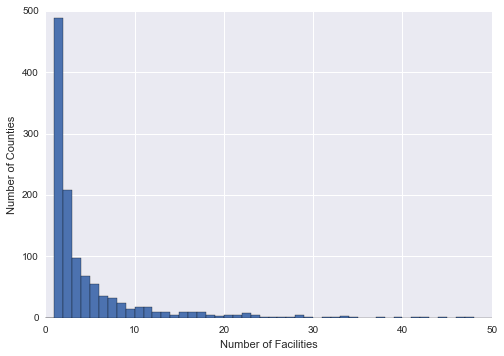

In [30]:
df = pd.DataFrame(rehab_dict)
fig = plt.hist(df['n_facilities'], bins=np.arange(0, 51, 1)) #max(df['n_facilities'])
plt.xlabel('Number of Facilities');
plt.ylabel('Number of Counties')